In [1]:
import pandas as pd
import numpy as np
import altair as alt
from altair import datum, expr
import matplotlib.pyplot as plt
import datetime as dt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
tchrs = pd.read_stata("teacher_data.dta", convert_categoricals=False)
csos = pd.read_stata("cso_data.dta", convert_categoricals=False)
dirs = pd.read_stata("director_data.dta", convert_categoricals=False)

In [4]:
print(f"The Teacher dataset contains {tchrs.shape[0]} records\nThe CSO dataset contains {csos.shape[0]} records\nThe Director dataset contains {dirs.shape[0]} records")

The Teacher dataset contains 709 records
The CSO dataset contains 132 records
The Director dataset contains 203 records


The main questions we want to ask are documented in the [analysis plan](https://github.com/TSSlade/tusome-d4dm/blob/master/analysis_plan.md), which is an evolving document.

## Teacher Instrument

Here we begin exploring the data we obtained from interviewing the teachers.

In [6]:
tchr_ct = tchrs.shape[0]

Our dataset contains interviews with {{tchr_ct}} teachers.

### Teachers visited previously by CSOs

The underlying assumption of most of the interview protocol is that the teacher has had a coaching interaction with a CSO. The first issue we should then address is the proportion of teachers who have received a visit from a CSO.

In [7]:
never = 100 * ((tchr_ct - tchrs.vis_before.sum())/tchr_ct)

We see that {{np.round(never, decimals=2)}}% of teachers interviewed had never been previously visited by CSOs.

### Number of coaching visits in the last academic term

We have confirmed that the overwhelming majority of our teachers have been visited. We can have greater confidence in the responses they give us over the course of the interview if they have had a visit in the recent past. We therefore asked the teachers to tell us how many times they had been visited by their CSO in the preceding academic term (Term 2 of the Kenyan academic year, running from roughly May-July 2018).

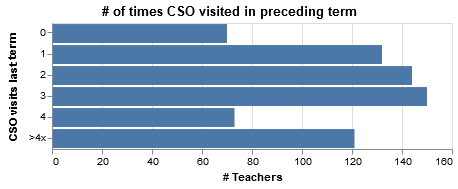

In [47]:
tchrs.vis_before_freq = tchrs.vis_before_freq.replace({55: ">4x"})
viscount_df = pd.DataFrame(tchrs.vis_before_freq.value_counts(sort=False)).rename_axis("prevterm_vis").reset_index()
viscount_df["pct"] = np.round(100 * (viscount_df.vis_before_freq / tchrs.vis_before.sum()), decimals=2)
more_than_monthly = viscount_df[viscount_df.prevterm_vis.isin([4, ">4x"])].pct.sum()
alt.Chart(viscount_df, title="# of times CSO visited in preceding term").mark_bar().encode(
    alt.Y("prevterm_vis:O", title="CSO visits last term"),
    alt.X("vis_before_freq:Q", title="# Teachers"),
    tooltip="pct")

We see that roughly {{viscount_df[viscount_df.prevterm_vis==0].pct[0]}}% of the respondents, while they'd been visited by a CSO in the past, had not been visited in the preceding term. However, {{viscount_df[viscount_df.prevterm_vis.isin([1, 2, 3])].pct.sum()}}% of the respondents were visited between once per term and once per month. {{more_than_monthly}}% of the teachers were visited by their CSOs more frequently than monthly.

29.39

In [72]:
visact_df = pd.DataFrame.from_dict({"activities": ["Assessed pupils",
                                                   "Talked to HT",
                                                   "Provided feedback on lesson",
                                                   "Had general talk",
                                                   "Other"],
                                    "tchrs_reporting": [tchrs.vis_act_kids.sum(),
                                                        tchrs.vis_act_ht.sum(),
                                                        tchrs.vis_act_fdbk.sum(),
                                                        tchrs.vis_act_gen.sum(),
                                                        tchrs.vis_act_other.sum()]})
visact_df.tchrs_reporting = np.round(visact_df.tchrs_reporting.apply(lambda x: 100 * (x/tchr_ct)), decimals=2)
visact_df

,activities,tchrs_reporting
0,Assessed pupils,83.50
1,Talked to HT,62.62
2,Provided feedback on lesson,89.56
3,Had general talk,45.98
4,Other,16.36


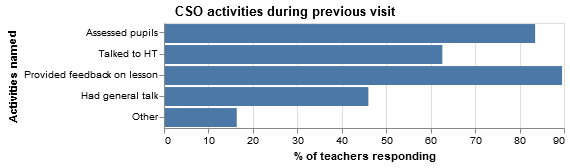

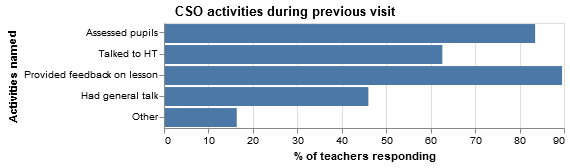

In [73]:
alt.Chart(visact_df, title="CSO activities during previous visit").mark_bar().encode(
alt.Y("activities:O", 
      title="Activities named",
      sort = alt.EncodingSortField(field="tchrs_reporting", op="values", order="ascending")),
alt.X("tchrs_reporting:Q",
      title="% of teachers responding"))

In [77]:
tchrs[tchrs.vis_act_other_det.notna() & (tchrs.vis_act_other_det != "")].vis_act_other_det.sample(20)

3      asks where I have questions and gives me guidance, has also done TIPAD                                                                                                                                                                                                                                                         
2      requests me to prepare for the lesson in adavnace and details of the lesson, boys and girls                                                                                                                                                                                                                                    
400    spoke to head teacher,observed my class,asesed pupils and gave me feedback                                                                                                                                                                                                                                                     
631    She looks at

## CSO Instrument

Here we begin exploring the data we obtained from interviewing the CSOs.

### Length of experience using tablet-based Tangerine
_When did you first receive a tablet from Tusome or PRIMR?_

We want to convert the year/month CSOs provided into a number so we can work with it easily. We'll make the simplifying assumption that the tablet was received on the first day of the month they provided, and that this interview was conducted on the first day of the month. Neither of those are true, but the marginal days are unlikely to make a practical difference in a CSO's facility with the tool

In [5]:
now = dt.datetime(2018, 10, 1)
csos["tab_usage"] = pd.to_timedelta(now - pd.to_datetime({"year": csos.recd_tab_yr, "month": csos.recd_tab_month, "day": 1})).dt.days

We'll also want to convert the duration to months, since that will be easier to digest, and filter out any missing values.

In [6]:
tab_usage = pd.DataFrame(csos[csos.tab_usage.notna()].tab_usage / 30)
# tab_usage

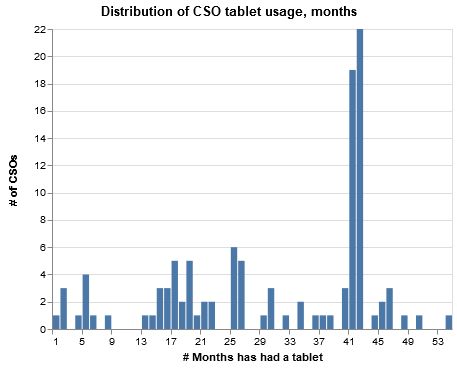

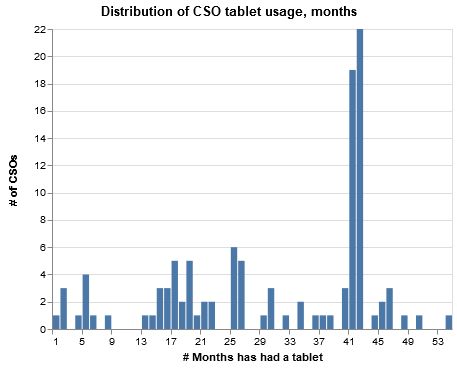

In [7]:
alt.Chart(tab_usage, title="Distribution of CSO tablet usage, months").mark_bar().encode(
    alt.X("tab_usage:Q", 
          bin=alt.BinParams(step=1), title="# Months has had a tablet"),
    alt.Y("count()", title="# of CSOs"))

We see that the majority of our CSOs have had their tablets for roughly 42 months (3.5 years). This is in keeping with the beginning of the Tusome program, and is as expected. CSOs who have had their tablets for longer are likely veterans of the PRIMR program (Tusome's predecessor); those who have had tablets for fewer months may have assumed their roles more recently. (CSO turnover due to retirement, promotion, maternity leave, etc. is an issue which Tusome is constantly needing to manage.)

### Proportion of CSOs reporting use of each application

_Which applications do you use frequently when supporting teachers? ...After recording unprompted responses, read the list of options and record responses._
  + Tangerine Tutor
  + Papaya
  + Tusome Books (in Adobe Acrobat)
  + Tusome Videos (in MX Player)

The CSOs' tablets come equipped with several tools meant to support their efforts as instructional coaches. These include the [_Tangerine:Tutor_](http://www.tangerinecentral.org/tutor/) application, the [_Papaya_](http://schoolsnetkenya.com/tusome-early-literacy-programme-sounds-application/) application, PDF versions of Tusome's instructional materials (pupil's books and teacher's guides), and videos that model effective instructional delivery.

We are interested in which of those tools CSOs use, and how frequently. We will provide an analysis of their unprompted free-response answers to the question above. For the moment, we note the tools they said they use when we explicitly prompted them with the list of tools available.

In [8]:
app_users = {"tutor": csos.freqapps_tt_promp.sum(),
         "papaya": csos.freqapps_papaya_promp.sum(),
         "books": csos.freqapps_bks_promp.sum(),
         "videos": csos.freqapps_vids_promp.sum()}
app_usage = pd.DataFrame.from_dict(app_users, orient="index", columns=["ct"])
app_usage["pct"] = 100 * np.round(app_usage["ct"] / csos.shape[0], decimals=3)
app_usage = app_usage.rename_axis("app").reset_index()

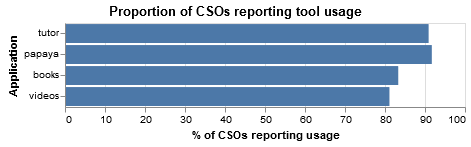

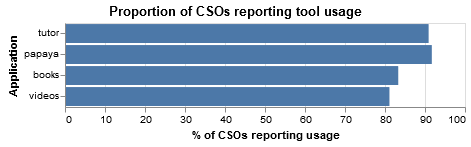

In [11]:
alt.Chart(app_usage, title="Proportion of CSOs reporting tool usage").mark_bar().encode(
    alt.Y("app:O",
          title="Application",
          sort = alt.EncodingSortField(field="pct", op="values", order="ascending"),
          ),
    alt.X("pct:Q", title="% of CSOs reporting usage"),
    tooltip="pct")

The overwhelming majority of the CSOs report using all of the applications. That said, the videos and books are used less frequently.

### Proportion of CSOs who refer to Tangerine to provide post-observation feedback

_Do you refer to Tangerine when giving teachers feedback after observing a lesson?_

The _Tangerine:Tutor_ application analyzes the pattern of the CSO's responses to the observation items and surfaces actionable feedback that could be share with the teacher to improve her or his instruction. While the auto-generated feedback is intended as a tool to help CSOs give more effective guidance to teachers, it can be quite extensive and is not prioritized. We were interested to know whether the CSOs make reference to the application's auto-generated feedback when they hold their post-observation debriefing session with the teacher.

In [12]:
100 * np.round(csos.ref_tang_fdbk.sum() / csos.shape[0], decimals=3)

97.7

Again, the overwhelming majority of CSOs report using the auto-generated feedback when holding their debrief session with the teacher. We will separately provide an analysis of their open-ended answers regarding _what_ they refer to and what they find most useful.

### Proportion of CSOs who use Tangerine to plan their work

_Do you refer to Tangerine to help you plan your work when you are **not** either observing a teacher or giving the teacher feedback?_

Version 3 of the _Tangerine:Tutor_ application features a screen which allows a CSO to see schools they have visited and which they have not. We were interested to know whether the CSOs are leveraging this feature—or others, such as the pupils' fluency rates, which are reported in the feedback—to make decisions about which schools to visit in the future.

In [13]:
100 * np.round(csos.refer_tang_nonobs.sum() / csos.shape[0], decimals=3)

59.8

Fewer than two-thirds of CSOs refer to Tangerine to plan their work. A sampling of their reasons is provided surfaced below:

In [14]:
pd.set_option('display.max_colwidth', -1)
csos[csos.tang_nonobs_nowhynot.notnull() & (csos.tang_nonobs_nowhynot != "")].tang_nonobs_nowhynot.sample(10)

101    I normally use it for the observation and writing reports                                                                
96     Tangerine might capture GPS and you will be seen like a cheat and it's not good. I only use it while supporting teachers.
74     i fear to accidentally inerrupt the tangerine                                                                            
107    Because to me Tangerine is meant for guidance during the specific lesson observation.                                    
123    I have a lot of tasks to look into that are not so much related to the Tusome content on the Tangerine                   
39     I just use it to observe lessons                                                                                         
36     I was not trained on how to do it                                                                                        
93     I normally use it for the observation and writing reports                                 

This result surfaces a few issues Tusome might consider addressing next time CSOs receive a refresher training on Tangerine's use.
  1. A lack of awareness of how the information provided by the tablet (schools visited and not visited) could be operationalized
  1. A fear that they would be accused of falsifying observation data, rooted specifically in a misunderstanding of the application's GPS-capture functionality
  1. A mental compartmentalization of Tangerine as being a Tusome-specific tool, not for use in broader contexts

Other reasons given suggest that the need which Tangerine might fill is already being addressed separately.
  1. The CSO keeps a personal record (outside of the tablet) in which they track school visitation
  1. The CSO has prepared a work schedule, and uses that as their guide until the month's activities have concluded.

### Frequency with which users refer to the application

\[If the CSO refers to the Tangerine for planning purposes\], _how often do you reference the data?_



In [15]:
tchk_freq = csos[csos.freq_refer_tang_plan.notna()].freq_refer_tang_plan.sort_values().value_counts(sort=False).to_frame(name="ct")
tchk_freq = tchk_freq.rename_axis("frequency").reset_index()
tchk_freq["frequency"] = tchk_freq["frequency"].replace({
    1: "Daily", 
    2: "Weekly",
    3: "Monthly",
    4: "Termly"})
tchk_freq["sort_order"] = tchk_freq.index

It appears that among the CSOs who check the application, it is most common to check it at least weekly.

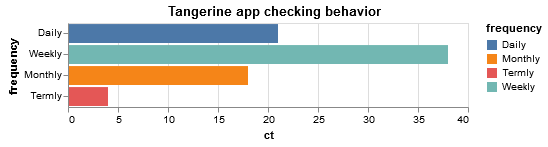

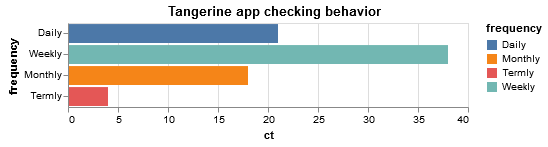

In [16]:
alt.Chart(tchk_freq, title="Tangerine app checking behavior").mark_bar().encode(
    alt.X("ct:Q"),
    alt.Y("frequency:O", sort = alt.EncodingSortField(field="sort_order:Q", op="values", order="ascending")),
    color = "frequency")

### CSO reference to the Tangerine Dashboard

_In the last term, how often did you look at the Tangerine Dashboard?_

The data that is generated by the CSOs' lesson observations is uploaded to the cloud and reported on the [Tangerine Dashboard](http://tools.tusome.tangerinecentral.org/_csv/report/group-national_tablet_program/00b0a09a-2a9f-baca-2acb-c6264d4247cb,c835fc38-de99-d064-59d3-e772ccefcf7d/2018/1/ep8yqMKT.html#tutor). This Dashboard is reviewed by senior management within the Ministry of Education: the Principal Secretary, his Directors, and their deputies. It is also sent to the Directors of MOE and TSC at the County level. As these latter personnel oversee the CSOs, the Dashboard may have an effect ...